# Creating the Financial Statements

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

In [10]:
years = ['2018A', '2019B', '2020P', '2021P', '2022P', '2023P']
sales = pd.Series(index=years)
sales['2018A'] = 31
sales

2018A    31.0
2019B     NaN
2020P     NaN
2021P     NaN
2022P     NaN
2023P     NaN
dtype: float64

In [12]:
gr_rate = 0.1
for year in range(1, 6):
    sales[year] = sales[year - 1] * (1 + gr_rate)
    
sales

2018A    31.00000
2019B    34.10000
2020P    37.51000
2021P    41.26100
2022P    45.38710
2023P    49.92581
dtype: float64

In [15]:
ebitda_margin = 0.14
depr_percent = 0.032
ebitda = sales * ebitda_margin
depreciation = sales * depr_percent
ebit = ebitda - depreciation
nwc_pct = 0.24
nwc = sales * nwc_pct
change_in_nwc = nwc.shift(1) - nwc
capex_pct = depr_percent
capex = -(sales*capex_pct)
tax_rate = 0.25
tax_payment = -ebit * tax_rate
tax_payment = tax_payment.apply(lambda x: min(x,0))
free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
free_cash_flow

2018A         NaN
2019B    2.018100
2020P    2.219910
2021P    2.441901
2022P    2.686091
2023P    2.954700
dtype: float64

In [27]:
cost_of_capital = 0.12
terminal_growth = 0.02
terminal_value = ((free_cash_flow[-1] * (1 + terminal_growth)) / (cost_of_capital - terminal_growth))
discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,6)]
dcf_value = (sum(free_cash_flow[1:] * discount_factors) + terminal_value * discount_factors[-1])
dcf_value


25.79438401113792

In [28]:
output = pd.DataFrame([sales, ebit, free_cash_flow], index=['Sales', 'EBIT', 'Free cash flow']).round(1)

output.to_excel('Python DCF model output.xlsx')
output

,2018A,2019B,2020P,2021P,2022P,2023P
Sales,31.0,34.1,37.5,41.3,45.4,49.9
EBIT,3.3,3.7,4.1,4.5,4.9,5.4
Free cash flow,NaN,2.0,2.2,2.4,2.7,3.0


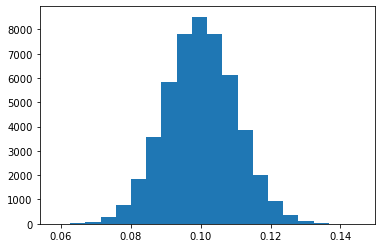

In [50]:
iterations = 50000
sales_gr_dist = np.random.normal(loc=0.1, scale=0.01, size=iterations)
ebitda_margin_dist = np.random.normal(loc=0.14, scale=0.02, size=iterations)
nwc_pct_dist = np.random.normal(loc=0.24, scale=0.01, size=iterations)
plt.hist(sales_gr_dist, bins=20)
plt.show()

In [51]:
def run_mcs():
    
    # Create probability distributions
    sales_growth_dist = np.random.normal(loc=0.1, scale=0.01, size=iterations)
    ebitda_margin_dist = np.random.normal(loc=0.14, scale=0.02, size=iterations)
    nwc_percent_dist = np.random.normal(loc=0.24, scale=0.01, size=iterations)
    
    # Calculate DCF value for each set of random inputs
    output_distribution = []
    for i in range(iterations):
        for year in range(1, 6):
            sales[year] = sales[year - 1] * (1 + sales_growth_dist[0])
        ebitda = sales * ebitda_margin_dist[i]
        depreciation = (sales * depr_percent)
        ebit = ebitda - depreciation
        nwc = sales * nwc_percent_dist[i]
        change_in_nwc = nwc.shift(1) - nwc 
        capex = -(sales * capex_pct)
        tax_payment = -ebit * tax_rate
        tax_payment = tax_payment.apply(lambda x: min(x, 0))
        free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
        
        # DCF valuation
        terminal_value = (free_cash_flow[-1] * 1.02) / (cost_of_capital - 0.02)
        free_cash_flow[-1] += terminal_value
        discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,6)]
        dcf_value = sum(free_cash_flow[1:] * discount_factors )
        output_distribution.append(dcf_value)
    
    return output_distribution

Wall time: 3min 27s


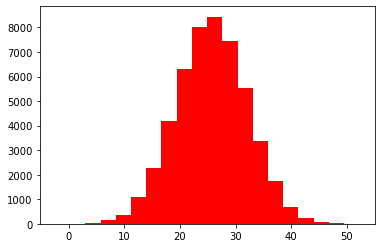

In [52]:
%time plt.hist(run_mcs(), bins=20, color='r')
plt.show()

In [53]:
years = 5
starting_sales = 31.0
capex_percent = depr_percent = 0.032
sales_growth = 0.1
ebitda_margin = 0.14
nwc_percent = 0.24
tax_rate = 0.25
# DCF assumptions
r = 0.12
g = 0.02
# For MCS model
iterations = 1000
sales_std_dev = 0.01
ebitda_std_dev = 0.02
nwc_std_dev = 0.01


def run_mcs():
    
    # Generate probability distributions
    sales_growth_dist = np.random.normal(loc=sales_growth, scale=sales_std_dev, size=(years, iterations))
    ebitda_margin_dist = np.random.normal(loc=ebitda_margin, scale=ebitda_std_dev, size=(years, iterations))
    nwc_percent_dist = np.random.normal(loc=nwc_percent, scale=nwc_std_dev, size=(years, iterations))
    
    # Calculate free cash flow
    sales_growth_dist += 1
    for i in range(1, len(sales_growth_dist)):
        sales_growth_dist[i] *= sales_growth_dist[i-1]
    sales = sales_growth_dist * starting_sales
    ebitda = sales * ebitda_margin_dist
    ebit = ebitda - (sales * depr_percent)
    tax = -(ebit * tax_rate)
    np.clip(tax, a_min=None, a_max=0)
    nwc = nwc_percent_dist * sales
    starting_nwc = starting_sales * nwc_percent
    prev_year_nwc = np.roll(nwc, 1, axis=0)
    prev_year_nwc[0] = starting_nwc
    delta_nwc = prev_year_nwc - nwc
    capex = -(sales * capex_percent)
    free_cash_flow = ebitda + tax + delta_nwc + capex
    # Discount cash flows to get DCF value
    terminal_value = free_cash_flow[-1] * (1 + g) / (r - g)
    discount_rates = [(1 / (1 + r)) ** i for i in range (1,6)]
    dcf_value = sum((free_cash_flow.T * discount_rates).T) 
    dcf_value += terminal_value * discount_rates[-1]
        
    return dcf_value

Wall time: 57.8 ms


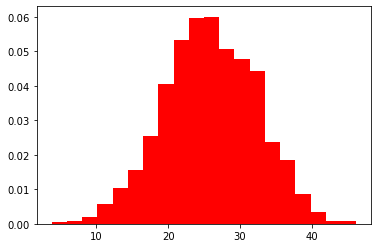

In [54]:
%time plt.hist(run_mcs(), bins=20, density=True, color="r")
plt.show()